<a href="https://colab.research.google.com/github/TTTanya/Predict_Winner/blob/main/PredictWinner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting winner team in 'Dota2' depending on first 5 minutes of the game**

In [ ]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
from google.colab import files
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from keras.optimizers import SGD
import io
%matplotlib inline 

In [ ]:
train = files.upload()

Saving features.csv to features.csv


In [ ]:
df = pd.read_csv(io.BytesIO(train['features.csv']))

In [ ]:
df.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [ ]:
df.describe()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,97230.000000,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,97230.000000,97230.000000,97230.000000,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,57185.416744,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,...,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,2.994775,3.312527,2.431719,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,33007.123878,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291,8.917997,0.642908,0.616181,2.427832,32.608231,1.095842,553.020429,453.165214,8.948413,...,547.308063,448.416794,8.872503,0.658713,0.602357,2.427417,32.535112,1.091848,550.887551,449.877513,8.882013,0.659190,0.605956,2.432850,82.625879,0.499527,2.886984,2.870915,61.427907,15.814209,34.604997,1.933283,1.154414,0.811435,0.725331,39.508650,62.442018,15.261950,34.137158,1.907288,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,0.000000,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000

In [ ]:
df.columns[df.isnull().any()]

Index(['first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time',
       'radiant_flying_courier_time', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_first_ward_time'],
      dtype='object')

In [ ]:
df.select_dtypes(include='object').count()

Series([], dtype: int64)

In [ ]:
df_null_cols = df.columns[df.isnull().any()]

In [ ]:
df_null = pd.DataFrame(df, columns=df_null_cols)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13619ab278>,
      dtype=object)

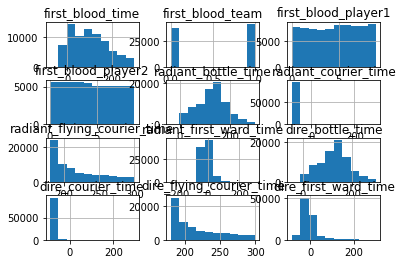

In [ ]:
df_null.hist()

In [ ]:
def fill_num(x, df):
   df[x].fillna(df[x].median(), inplace = True)

Fill NaN values with median

In [ ]:
for i in df.columns[df.isnull().any()]:
  if df[i].dtype != 'object':
    fill_num(i, df)

In [ ]:
df_cat_cols = df.filter(regex='_hero|lobby_type').columns

Make type of categorical features as 'object'

In [ ]:
df[df_cat_cols] = df[df_cat_cols].astype('object')

In [ ]:
test = files.upload()

Saving features_test.csv to features_test.csv


In [ ]:
df_test = pd.read_csv(io.BytesIO(test['features_test.csv']))

In [ ]:
for i in df_test.columns[df_test.isnull().any()]:
  if df_test[i].dtype != 'object':
    fill_num(i, df_test)

In [ ]:
df_test_cat_cols = df_test.filter(regex='_hero|lobby_type').columns

In [ ]:
df_test[df_test_cat_cols] = df_test[df_test_cat_cols].astype('object')

Concatenate training and testing dataframes to get the same amount of features

In [ ]:
df['label'] = 1
df_test['label'] = 0

concat_df = pd.concat([df , df_test])
columns_obj = concat_df.select_dtypes(include='object').columns
features_df = pd.get_dummies(concat_df, columns=columns_obj, dummy_na=True, drop_first=True)

In [ ]:
df = features_df[features_df['label'] == 1]
df_test = features_df[features_df['label'] == 0]

df = df.drop('label', axis=1)
df_test = df_test.drop('label', axis=1)

Summarize features of individual players to get general indicators for the whole team

In [ ]:
df['r_total_level'] = df.filter(regex='r._level').sum(axis=1)
df['r_total_gold'] = df.filter(regex='r._gold').sum(axis=1)
df['r_total_lh'] = df.filter(regex='r._lh').sum(axis=1)
df['r_total_kills'] = df.filter(regex='r._kills').sum(axis=1)
df['r_total_deaths'] = df.filter(regex='r._deaths').sum(axis=1)
df['r_total_items'] = df.filter(regex='r._items').sum(axis=1)

In [ ]:
df['d_total_level'] = df.filter(regex='d._level').sum(axis=1)
df['d_total_gold'] = df.filter(regex='d._gold').sum(axis=1)
df['d_total_lh'] = df.filter(regex='d._lh').sum(axis=1)
df['d_total_kills'] = df.filter(regex='d._kills').sum(axis=1)
df['d_total_deaths'] = df.filter(regex='d._deaths').sum(axis=1)
df['d_total_items'] = df.filter(regex='d._items').sum(axis=1)

In [ ]:
df.head()

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,...,d5_hero_83.0,d5_hero_84.0,d5_hero_85.0,d5_hero_86.0,d5_hero_87.0,d5_hero_88.0,d5_hero_89.0,d5_hero_90.0,d5_hero_91.0,d5_hero_92.0,d5_hero_93.0,d5_hero_94.0,d5_hero_95.0,d5_hero_96.0,d5_hero_97.0,d5_hero_98.0,d5_hero_99.0,d5_hero_100.0,d5_hero_101.0,d5_hero_102.0,d5_hero_103.0,d5_hero_104.0,d5_hero_105.0,d5_hero_106.0,d5_hero_109.0,d5_hero_110.0,d5_hero_112.0,d5_hero_nan,r_total_level,r_total_gold,r_total_lh,r_total_kills,r_total_deaths,r_total_items,d_total_level,d_total_gold,d_total_lh,d_total_kills,d_total_deaths,d_total_items
0,0,1430198770,5,2098,1489,20,0,0,7,3,842,991,10,0,0,4,5,1909,1143,10,0,0,8,3,757,741,6,0,0,7,3,732,658,4,0,1,11,3,1058,996,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,5022,50,0,1,37,18,5021,52,1,0,33
1,1,1430220345,4,1188,1033,9,0,1,12,4,1596,993,10,0,1,7,4,1506,1502,18,1,0,7,3,669,631,7,0,0,7,2,415,539,1,0,0,5,5,1960,1384,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,4698,45,1,2,38,17,5505,43,2,1,41
2,2,1430227081,4,1319,1270,22,0,0,12,3,1314,775,6,0,0,6,3,1297,909,0,1,0,6,5,2360,2096,26,1,1,6,3,1395,1627,27,0,0,9,5,2305,2028,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,6677,81,2,1,39,18,5786,70,1,2,42
3,3,1430263531,4,1779,1056,14,0,0,5,2,539,539,1,0,0,6,5,2037,1139,15,0,0,6,2,591,499,0,0,0,6,3,712,1075,12,0,0,6,5,1878,1174,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,4308,42,0,0,29,16,4729,51,0,0,37
4,4,1430282290,4,1431,1090,8,1,0,8,2,629,552,0,0,1,7,3,884,927,0,1,0,8,3,925,1439,16,1,0,11,4,1482,880,7,0,0,8,3,704,586,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,4888,31,3,1,42,18,5068,46,1,3,40


Drop features that 'look into the future'

In [ ]:
X_train = df.drop(['radiant_win', 'duration','radiant_win','tower_status_radiant','tower_status_dire','barracks_status_radiant','barracks_status_dire'], axis = 1)
y_train = df['radiant_win']

In [ ]:
y_train = y_train.astype('int')

In [ ]:
df['match_id'].groupby(df['radiant_win']).count()

radiant_win
0.0    46816
1.0    50414
Name: match_id, dtype: int64

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
kfold = KFold(shuffle=True, random_state=42)

In [ ]:
def cross_score(clf, X_train, y_train, kfold):
  return cross_val_score(estimator = clf, X = X_train, y = y_train, cv = kfold, scoring = 'roc_auc').mean()

In [ ]:
def find_best(best_score, score, model):
  if score > best_score:
    best_score = score
  return model

In [ ]:
best_score = 0

Test gradient boosting algorithm

In [ ]:
def grad_boost(X_train, y_train):
  clf_GB = GradientBoostingClassifier(random_state=42) 
  params = {'n_estimators': [200, 250], 'max_depth': range(3,4) }
  grid_GB = GridSearchCV(clf_GB, params, cv=5, return_train_score=True)
  grid_GB.fit(X_train, y_train)
  grid_GB_best = grid_GB.best_estimator_
  grid_GB_best.fit(X_train, y_train)
  return cross_score(grid_GB_best, X_train, y_train, kfold), grid_GB.best_params_

In [ ]:
score, parameters = log_reg(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Gradient boosting classifier')

In [ ]:
score, parameters = log_reg(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Gradient boosting classifier with scaled X')

Test logistic regression with different 'C'

In [ ]:
def log_reg(X_train, y_train):
  clf_LR = LogisticRegression(tandom_state = 241).fit(X_train, y_train)
  params = {'C': [1e-3, 1e-2, 1e-1, 1, 10], 'penalty': ['l1', 'l2']}
  grid_LR = GridSearchCV(clf_LR, params, cv=5, return_train_score=True)
  grid_LR.fit(X_train, y_train)
  grid_best_LR = grid_LR.best_estimator_
  grid_best_LR.fit(X_train, y_train)
  return cross_score(clf_LR, X_train, y_train, kfold), grid_LR.best_params_

In [ ]:
score, parameters = log_reg(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Logistic regression')

In [ ]:
score, parameters = log_reg(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)
best_model = find_best(best_score, score, model='Logistic regression with scaled X')

In [ ]:
best_model

In [ ]:
best_clf = GradientBoostingRegressor(random_state=42, n_estimators = 250)
best_clf.fit(X_train, y_train)

In [ ]:
X_test = df_test
X_test = X_test.drop(['match_id', 'radiant_win'], axis=1)

In [ ]:
X_test.head()

In [ ]:
pred_GB = best_clf.predict(X_test)

In [ ]:
pred_GB

In [ ]:
model_GB_df = pd.DataFrame({'match_id': df_test['Id'], 'radiant_win': [i for i in pred_GB]})
model_GB_df.to_csv('pred_winner.csv', index = False)